# Power Outage Time Prediction

**Name(s)**: Anirudh Indraganti

**Website Link**: https://aindragaofficial.github.io/PowerOutageModel/

## Code

In [13]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.preprocessing import FunctionTransformer, StandardScaler

import plotly.express as px
pd.options.plotting.backend = 'plotly'
from matplotlib import pyplot as plt

### Framing the Problem

We are going to try and predict the duration of outages.

In [14]:
initial_outages = pd.read_excel('data/outage.xlsx', header=5)
initial_outages.drop(0, inplace=True)
initial_outages.drop(columns=['variables', 'OBS'], inplace=True)
drop_missing_time = initial_outages.loc[
        (initial_outages['OUTAGE.START.DATE'].isna() | \
         initial_outages['OUTAGE.START.TIME'].isna()) | \
        (initial_outages['OUTAGE.RESTORATION.DATE'].isna() |\
        initial_outages['OUTAGE.RESTORATION.TIME'].isna())
    ].index
initial_outages.drop(drop_missing_time, inplace=True)
initial_outages.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
1,2011.0,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,17:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,2014.0,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:38:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,2010.0,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,20:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,2012.0,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,04:30:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
5,2015.0,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,02:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


In [15]:
clean_outages = initial_outages.assign(
    **{
        'YEAR': initial_outages['YEAR'].astype(int),
        'MONTH': initial_outages['MONTH'].astype(int),
        'OUTAGE.START.TIME': pd.to_datetime(initial_outages['OUTAGE.START.DATE']) +\
            pd.to_timedelta(initial_outages['OUTAGE.START.TIME']\
            .astype(str, errors='ignore')),
        'OUTAGE.RESTORATION.TIME': pd.to_datetime(initial_outages\
                ['OUTAGE.RESTORATION.DATE']) +\
              pd.to_timedelta(initial_outages['OUTAGE.RESTORATION.TIME']\
                .astype(str, errors='ignore')),
        'OUTAGE.DURATION': initial_outages['OUTAGE.DURATION'] / 60
    }
)
clean_outages.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,2011-07-01 17:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,2014-05-11 18:38:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,2010-10-26 20:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,2012-06-19 04:30:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,2015-07-18 02:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


In [16]:
def nan_stats(df: pd.DataFrame):
    for col in df.columns:
        current_stats = df[col].value_counts(dropna=False)
        na = current_stats[current_stats.index.isna()].values
        current_total = current_stats.sum()
        if len(na) == 0:
            print(f'{col}: 0')
        else:
            print(f'{col}: {na[0] / current_total}')


In [17]:
clean_outages_2 = clean_outages.assign(
    **{
        'CAUSE.CATEGORY.DETAIL': clean_outages['CAUSE.CATEGORY.DETAIL']\
            .replace(np.NaN, 'unkown'),
        'CLIMATE.REGION': clean_outages['CLIMATE.REGION']\
            .replace(np.NaN, 'Tropical')
    }
)
clean_outages_2 = clean_outages_2.drop(columns=[\
    'HURRICANE.NAMES', 'DEMAND.LOSS.MW', \
    'OUTAGE.START.DATE', 'OUTAGE.RESTORATION.DATE'
    ], inplace=False)
clean_outages_2.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.TIME,OUTAGE.RESTORATION.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 17:00:00,2011-07-03 20:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 18:38:00,2014-05-11 18:39:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 20:00:00,2010-10-28 22:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 04:30:00,2012-06-20 23:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 02:00:00,2015-07-19 07:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


In [18]:
official_power_outage_df = clean_outages_2.drop(columns=[\
    'YEAR', 'MONTH', 'OUTAGE.RESTORATION.TIME', \
    'POSTAL.CODE', 'POPULATION', 'CUSTOMERS.AFFECTED'\
    ], inplace=False)
official_power_outage_df.head()

,U.S._STATE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.TIME,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,OUTAGE.DURATION,RES.PRICE,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
1,Minnesota,MRO,East North Central,-0.3,normal,2011-07-01 17:00:00,severe weather,unkown,51.0,11.6,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,Minnesota,MRO,East North Central,-0.1,normal,2014-05-11 18:38:00,intentional attack,vandalism,0.016667,12.12,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,Minnesota,MRO,East North Central,-1.5,cold,2010-10-26 20:00:00,severe weather,heavy wind,50.0,10.87,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,Minnesota,MRO,East North Central,-0.1,normal,2012-06-19 04:30:00,severe weather,thunderstorm,42.5,11.79,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
5,Minnesota,MRO,East North Central,1.2,warm,2015-07-18 02:00:00,severe weather,unkown,29.0,13.07,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


In [19]:
official_power_outage_df = official_power_outage_df.loc[:, \
        ~official_power_outage_df.columns.str.contains('gsp', case=False)]
official_power_outage_df = official_power_outage_df.loc[:, \
        ~official_power_outage_df.columns.str.contains('util', case=False)]
official_power_outage_df = official_power_outage_df.loc[:, \
        ~official_power_outage_df.columns.str.contains('price', case=False)]
official_power_outage_df = official_power_outage_df.loc[:, \
        ~official_power_outage_df.columns.str.contains('sales', case=False)]
official_power_outage_df = official_power_outage_df.loc[:, \
        ~official_power_outage_df.columns.str.contains('percen', case=False)]
official_power_outage_df = official_power_outage_df.loc[:, :'OUTAGE.DURATION']
official_power_outage_df.head()

,U.S._STATE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.TIME,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,OUTAGE.DURATION
1,Minnesota,MRO,East North Central,-0.3,normal,2011-07-01 17:00:00,severe weather,unkown,51.0
2,Minnesota,MRO,East North Central,-0.1,normal,2014-05-11 18:38:00,intentional attack,vandalism,0.016667
3,Minnesota,MRO,East North Central,-1.5,cold,2010-10-26 20:00:00,severe weather,heavy wind,50.0
4,Minnesota,MRO,East North Central,-0.1,normal,2012-06-19 04:30:00,severe weather,thunderstorm,42.5
5,Minnesota,MRO,East North Central,1.2,warm,2015-07-18 02:00:00,severe weather,unkown,29.0


In [20]:
official_power_outage_df.columns

Index(['U.S._STATE', 'NERC.REGION', 'CLIMATE.REGION', 'ANOMALY.LEVEL',
       'CLIMATE.CATEGORY', 'OUTAGE.START.TIME', 'CAUSE.CATEGORY',
       'CAUSE.CATEGORY.DETAIL', 'OUTAGE.DURATION'],
      dtype='object')

### Baseline Model

In [21]:
def extract_datetime_cols(df: pd.DataFrame):
    return df.assign(**{
        'YEAR': df['OUTAGE.START.TIME'].dt.year,
        'MONTH': df['OUTAGE.START.TIME'].dt.month,
        'DAY': df['OUTAGE.START.TIME'].dt.day, 
        'HOUR': df['OUTAGE.START.TIME'].dt.hour,
        'MIN': df['OUTAGE.START.TIME'].dt.minute
    }).drop(columns='OUTAGE.START.TIME', inplace=False)

In [22]:
def train_base_model(X_train_df: pd.DataFrame, y_train_ser: pd.Series):
    X_train_df = X_train_df[['NERC.REGION', 'ANOMALY.LEVEL']]
    transformers = [
        ('NERC.REGION', OrdinalEncoder(), ['NERC.REGION']),
        ('ANOMALY.LEVEL', StandardScaler(), ['ANOMALY.LEVEL'])
    ]

    column_transformer = ColumnTransformer(transformers)
    pipeline = Pipeline([
        ('column_transform', column_transformer),
        ('regression', DecisionTreeRegressor(max_depth=2))
    ])

    return pipeline.fit(X_train_df, y_train_ser)

In [23]:
X = official_power_outage_df.drop(columns='OUTAGE.DURATION')
y = official_power_outage_df['OUTAGE.DURATION']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
baseline_model = train_base_model(X_train, y_train)

In [24]:
baseline_preds = baseline_model.predict(X_test)
rmse = np.sqrt(
    mean_squared_error(y_test, baseline_preds)
)
rmse

73.13748322195806

### Final Model

In [25]:
def best_final_model(X_train_df: pd.DataFrame, y_train_ser: pd.Series,\
                    alpha: int, l1: int):
    X_train_df = X_train_df[['NERC.REGION', 'ANOMALY.LEVEL', \
                             'OUTAGE.START.TIME', 'U.S._STATE']]

    transformers = [
        ('NERC.REGION', OrdinalEncoder(), ['NERC.REGION']),
        ('ANOMALY.LEVEL', StandardScaler(), ['ANOMALY.LEVEL']),
        ('OUTAGE.START.TIME', FunctionTransformer(extract_datetime_cols),\
          ['OUTAGE.START.TIME']),
        ("U.S._STATE", OrdinalEncoder(), ['U.S._STATE'])
    ]
    column_transform = ColumnTransformer(transformers)
    pipeline = Pipeline([
        ('column_transform', column_transform),
        ('regression', ElasticNet(alpha=alpha, l1_ratio=l1))
    ])

    return pipeline.fit(X_train_df, y_train_ser)


I planned to tune the 'alpha' and 'l1_ratio' hyperparameters in my ElasticNet regression model. I used these two features because they are the main features that are used to penalize terms in the ElasticNet regression model. It also is the best method for trying to combat the multicollinearity problem, as it has a direct effect on the regression function.

(71.39593079478831, [1.0, 0.97])

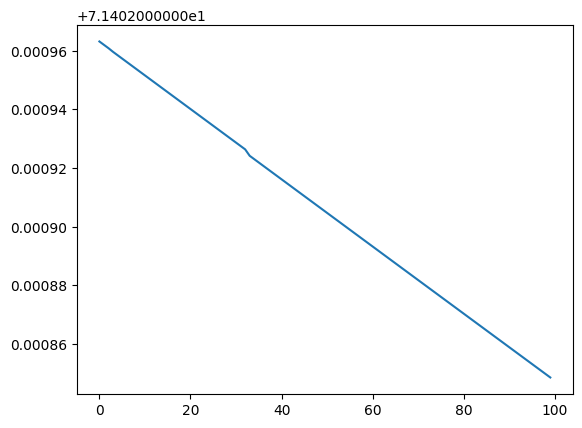

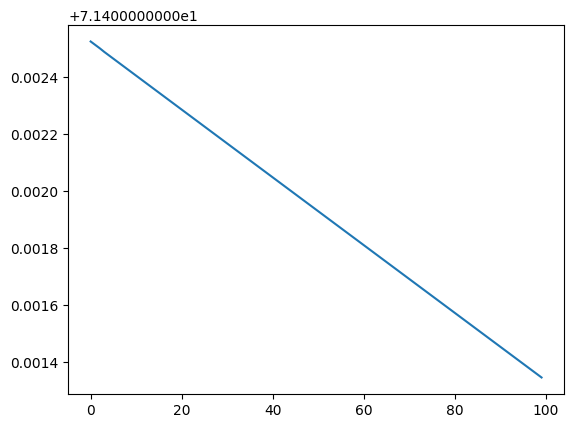

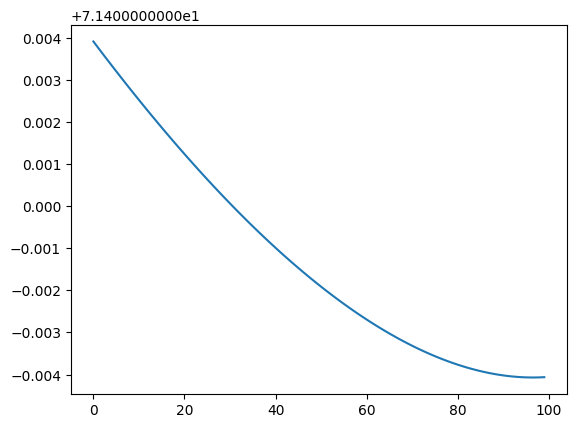

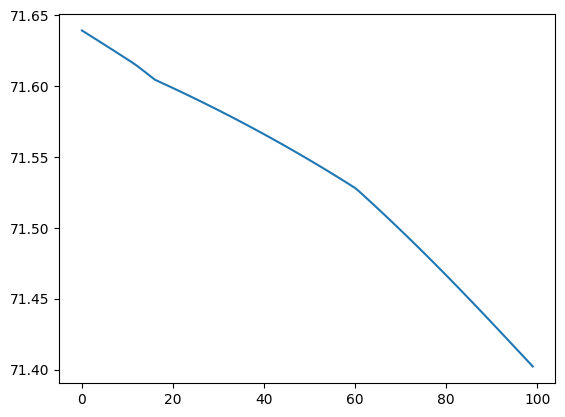

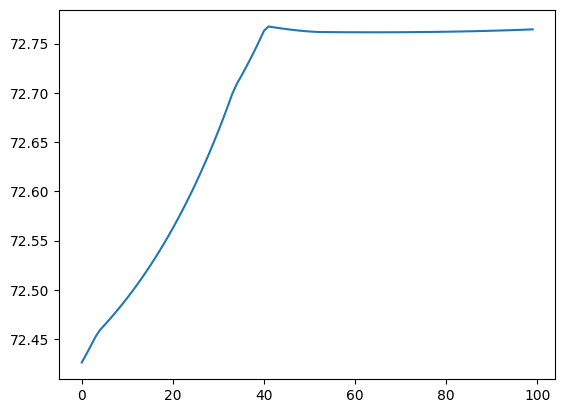

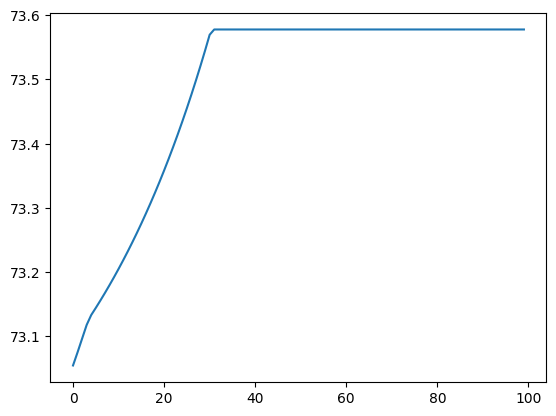

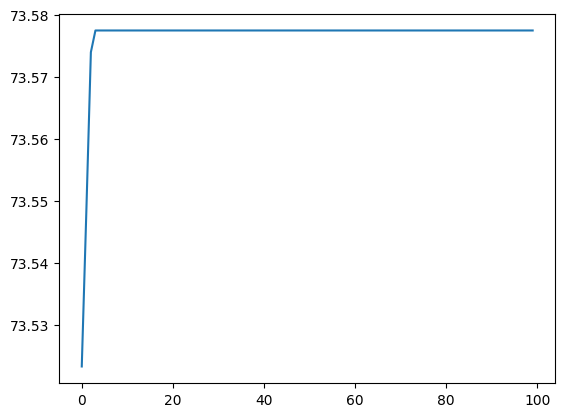

In [26]:
all_alphas = [0.01 * 10**(i) for i in range(0, 7)]
all_l1s = np.arange(0.01, 1.01, 0.01).tolist()
min_rmse = sys.maxsize
min_rmse_combo = [None, None]
for alpha in all_alphas:
    all_rmse = []
    for l1 in all_l1s:
        current_model = best_final_model(X_train, y_train, alpha, l1)
        current_preds = current_model.predict(X_test)
        current_rmse = np.sqrt(mean_squared_error(y_test, current_preds))
        if current_rmse < min_rmse:
            min_rmse = current_rmse
            min_rmse_combo[0] = alpha
            min_rmse_combo[1] = l1

        all_rmse.append(current_rmse)

    plt.figure()
    plt.plot(all_rmse)

min_rmse, min_rmse_combo

In [27]:
best_model = best_final_model(X_train, y_train, 1, 0.23)
best_preds = best_model.predict(X_test)
best_rmse = np.sqrt(mean_squared_error(y_test, best_preds))
best_rmse

71.40099675774087

### Fairness Analysis

Our analysis will try and determine if the RMSE of our model differs between the first half of a year (Jan - June) and the second half of the year (Jul - Dec).  Null Hypothesis: RMSE across both halves of the years is the same, meaning our model is fair.  Alternative Hypothesis: RMSE of the first half of the calendar is greater than the second half of the year, meaning our model isn't fair.  Significance Level: 0.01 Test Statistic: first_half_rmse - second_half_rmse

In [28]:
halves = (official_power_outage_df['OUTAGE.START.TIME'].dt.month > 6)\
    .replace({True: 'second', False: 'first'})
fairness_outages_df = official_power_outage_df.assign(
    **{
        'YEAR.HALF': halves
    }
)
fairness_outages_df.head()

,U.S._STATE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.TIME,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,OUTAGE.DURATION,YEAR.HALF
1,Minnesota,MRO,East North Central,-0.3,normal,2011-07-01 17:00:00,severe weather,unkown,51.0,second
2,Minnesota,MRO,East North Central,-0.1,normal,2014-05-11 18:38:00,intentional attack,vandalism,0.016667,first
3,Minnesota,MRO,East North Central,-1.5,cold,2010-10-26 20:00:00,severe weather,heavy wind,50.0,second
4,Minnesota,MRO,East North Central,-0.1,normal,2012-06-19 04:30:00,severe weather,thunderstorm,42.5,first
5,Minnesota,MRO,East North Central,1.2,warm,2015-07-18 02:00:00,severe weather,unkown,29.0,second


In [29]:
X_first = fairness_outages_df.loc[fairness_outages_df['YEAR.HALF'] == 'first']\
    .drop(columns=['OUTAGE.DURATION', 'YEAR.HALF'], inplace=False)
y_first = fairness_outages_df.loc[fairness_outages_df['YEAR.HALF'] == 'first',\
     'OUTAGE.DURATION']
first_preds = best_model.predict(X_first)

X_second = fairness_outages_df.loc[fairness_outages_df['YEAR.HALF'] == 'second']\
    .drop(columns=['OUTAGE.DURATION', 'YEAR.HALF'], inplace=False)
y_second = fairness_outages_df.loc[fairness_outages_df['YEAR.HALF'] == 'second', \
    'OUTAGE.DURATION']
second_preds = best_model.predict(X_second)

rmse_first = np.sqrt(mean_squared_error(y_first, first_preds))
rmse_second = np.sqrt(mean_squared_error(y_second, second_preds))

obs = rmse_first - rmse_second

results = pd.DataFrame(index=['first', 'second'], columns=['rmse'], \
        data=[rmse_first, rmse_second])
results

,rmse
first,107.555514
second,82.371976


In [30]:
shuffled = fairness_outages_df.copy(deep=True)
all_rmse = []
for _ in range(5_000):
    shuffled['YEAR.HALF'] = np.random.permutation(shuffled['YEAR.HALF'])
    current_X_first = shuffled.loc[shuffled['YEAR.HALF'] == 'first']\
        .drop(columns=['OUTAGE.DURATION', 'YEAR.HALF'], inplace=False)
    current_y_first = shuffled.loc[shuffled['YEAR.HALF'] == 'first',\
         'OUTAGE.DURATION']
    current_preds_first = best_model.predict(current_X_first)
    current_rmse_first = np.sqrt(mean_squared_error(current_y_first,\
                                 current_preds_first))
    current_X_second = shuffled.loc[shuffled['YEAR.HALF'] == 'second']\
        .drop(columns=['OUTAGE.DURATION', 'YEAR.HALF'], inplace=False)
    current_y_second = shuffled.loc[shuffled['YEAR.HALF'] == 'second', \
        'OUTAGE.DURATION']
    current_preds_second = best_model.predict(current_X_second)
    current_rmse_second = np.sqrt(mean_squared_error(current_y_second,\
                                 current_preds_second))
    all_rmse.append(current_rmse_first - current_rmse_second)

In [31]:
fig = px.histogram(all_rmse, nbins=20)
fig.add_vline(x=obs, line_color='red')

In [32]:
(np.array(all_rmse) >= obs).mean()

0.2056

In this instance, we fail to reject the null hypothesis. We cannot divert from the claim that the two groups have similar error rates.